In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
import torchvision.transforms as T
from collections import namedtuple

import gym
import numpy as np
import time
import cv2

import random
import math
from itertools import count


from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

Checking the Environment

In [2]:
env_id = 'CartPole-v0'

env = gym.make(env_id)
env.reset()
# for _ in range(400):
#     env.render()
#     time.sleep(0.01)
#     env.step(env.action_space.sample())   # take random actions
# env.close()

array([-0.0081191 ,  0.0180226 , -0.02702348,  0.04188462])

Checking and using if CUDA is available()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


Experience Replay to have memory for model

In [4]:
from collections import deque

class exp_replay(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return torch.cat(state), action, reward, torch.cat(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [5]:
epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.005
gamma = 0.99
batch_size = 32

replay_buffer_size = 20000
learning_rate = 0.0001
num_episodes = 200
target_update_freq = 10


In [6]:
def get_cart_loc(screen_width):
    world_width = env.x_threshold*2
    scale = screen_width/world_width
#     print(scale)
#     print(int(env.state[0]*scale + screen_width/2.0))
    return int(env.state[0]*scale + screen_width/2.0)

In [7]:
# def get_screen():
#         screen = env.render(mode='rgb_array')
#         screen_1 = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
#         r_screen = cv2.resize(screen_1, (84,84), interpolation=cv2.INTER_AREA)
#         r_screen = np.array(r_screen)
#         r_screen = np.expand_dims(r_screen,axis=0)
#         r_screen = torch.Tensor(r_screen)
#         return r_screen.unsqueeze(0).to(device)


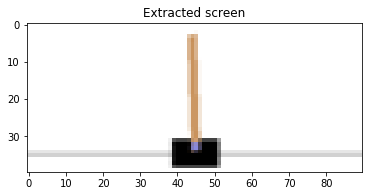

In [8]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])
def get_screen():
    screen = env.render(mode = 'rgb_array')
    ### Capture screen return in shape (H,W,C) = (400,600,3)
    
    ### Cart is in lower half of screen. We remove the unuseful part of environment
    screen_height, screen_width, _ = screen.shape
    screen = screen[int(screen_height*0.4):int(screen_height*0.8),:]  # Screen Shape is now (160,600,3)
#     print(screen.shape)

    view_width = int(screen_width*0.6) # width required when pole becomes horizontal. 
#     print(view_width//2)
    cart_loc = get_cart_loc(screen_width)

    ### Extract screen where cart is locaed and discard the remaining part
    if cart_loc < view_width//2:
        slice_range = slice(view_width)
    elif cart_loc > (screen_width - view_width//2):
        slice_range = slice(-view_width)
    else:
        slice_range = slice(cart_loc - view_width//2, cart_loc + view_width//2)
#     print(slice_range)
    screen = screen[:,slice_range,:]
#     print(screen.shape)
    
    
    ### Pytorch work wwith format (C,H,W). So we take transpose
    screen = screen.transpose((2,0,1))
#     print(screen.shape)
    
    ### Convert ot float and normalize
    screen = np.ascontiguousarray(screen, dtype = np.float32)/255
    
    ### Convert to tensor
    screen = torch.from_numpy(screen)
    
    ### Adding dimension for batch
    screen = resize(screen).unsqueeze(0).to(device)
#     print(screen.shape)
    return screen
    

### Image appears to be blur due to interpolation
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy())
plt.title('Extracted screen')
plt.show()

Deep Q-Network

In [9]:
class dqn(nn.Module):
    def __init__(self, h, w, outputs):
        super(dqn, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
                return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
#         print(convh, convw)
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [10]:
init_screen = get_screen()
init_screen = init_screen.squeeze(0)
# print(init_screen.shape[2])


num_actions = env.action_space.n
policy_net = dqn(init_screen.shape[1], init_screen.shape[2], num_actions).to(device)
target_net = dqn(init_screen.shape[1], init_screen.shape[2], num_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

criterion = nn.MSELoss()
optimizer = optim.Adam(policy_net.parameters(), lr = learning_rate)

memory = exp_replay(replay_buffer_size)

In [11]:
steps_done = 0
def select_action(state):
    global epsilon, epsilon_min
    sample = random.random()
    
#     eps_threshold = epsilon_min + (epsilon-epsilon_min)*math.exp(-1.*steps_done/epsilon_decay)
#     steps_done += 1
#     print(eps_threshold)
    if epsilon>epsilon_min:
        epsilon = epsilon - epsilon_decay
        
    print(epsilon)
    if sample < epsilon:
        action = env.action_space.sample()
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward
            
    else:
         with torch.no_grad():
            q_val = policy_net(state)
            action = torch.argmax(q_val).item()
            
    return action


def plot_durations(scores,pause):
    plt.ion()
    plt.figure(2)
    plt.clf()

    durations_t = torch.tensor(scores, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Scores')
    plt.plot(durations_t.numpy())
    # Take 20 episode averages and plot them too
    if len(durations_t) >= 20:
        means = durations_t.unfold(0, 20, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(19), means))
        plt.plot(means.numpy())

    plt.pause(pause)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [12]:
def learn():
    if len(memory) < batch_size:
        return
    
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = memory.sample(batch_size)
    reward_batch = torch.tensor(reward_batch, device = device)
    done_batch = torch.tensor(done_batch, device = device)
#     print(done_batch)


    q_val = policy_net(state_batch).to(device)
    q_next = target_net(next_state_batch).to(device).detach()
    q_target = policy_net(state_batch).to(device).detach()
    target_net.eval()

    batch_index = np.arange(batch_size)
    action_values = torch.max(q_next,1)[0]

    q_target[batch_index,action_batch] = reward_batch + gamma*action_values*done_batch
    
    loss = criterion(q_val, q_target).to(device)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [13]:
ep_reward = []

for ep in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    done = False
    total_reward  = 0
    while not done:
        action = select_action(state)
        _, reward, done, _ = env.step(action)
        
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        next_state = current_screen - last_screen
        
        
        memory.push(state, action, reward, next_state, done)
        learn()     # Learning of model with help of experience replay
        
        total_reward += reward
        state = next_state
        
    ep_reward.append(total_reward)
    # Update the target network, copying all weights and biases in DQN
    if ep % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())
print('Complete')
env.render()
env.close()

0.995
0.99
0.985
0.98
0.975
0.97
0.965
0.96
0.955
0.95
0.945
0.94
0.9349999999999999
0.9299999999999999
0.9249999999999999
0.9199999999999999
0.9149999999999999
0.9099999999999999
0.9049999999999999
0.8999999999999999
0.8949999999999999
0.8899999999999999
0.8849999999999999
0.8799999999999999
0.8749999999999999
0.8699999999999999
0.8649999999999999
0.8599999999999999
0.8549999999999999
0.8499999999999999
0.8449999999999999
0.8399999999999999
0.8349999999999999
0.8299999999999998
0.8249999999999998
0.8199999999999998
0.8149999999999998
0.8099999999999998
0.8049999999999998
0.7999999999999998
0.7949999999999998
0.7899999999999998
0.7849999999999998
0.7799999999999998
0.7749999999999998
0.7699999999999998
0.7649999999999998
0.7599999999999998
0.7549999999999998
0.7499999999999998
0.7449999999999998
0.7399999999999998
0.7349999999999998
0.7299999999999998
0.7249999999999998
0.7199999999999998
0.7149999999999997
0.7099999999999997
0.7049999999999997
0.6999999999999997
0.6949999999999997
0.6

0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918


0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918


0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918


0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918


0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918


0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918
0.00999999999999918


In [14]:
plot_durations(ep_reward,5)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>